In [107]:
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import wordnet as wn
from pprint import pprint
import torch.nn.functional as F
import os
import re
import glob
import tqdm 
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import pytorch_lightning as pl
from model import AutoEncoder, HookedModel, DictionnaryLearner, default_hookedmodel, default_ae
import networkx as nx
from wordnet_data.imagenet_classes_helpers import common_superclass_wnid, ImageNetHierarchy
import matplotlib.pyplot as plt
#%load_ext tensorboard

In [108]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Utils, loading model and data (loading ImageNet validation set takes roughly 1 min)

In [7]:
def load_model(generic_path, wandb_id, epoch = -1):
    path = os.path.join(generic_path, wandb_id, 'checkpoints')
    if epoch == -1:
        ## Create a list of all the epochs with a regex
        epochs = [int(re.findall(r'epoch=(\d+)', x)[0]) for x in os.listdir(path)]
        ## Get the last epoch
        epoch = max(epochs)
    ## Get the ckpt file starting with epoch={epoch}
    ckpt = [x for x in os.listdir(path) if x.startswith(f'epoch={epoch}')][0]
    model = DictionnaryLearner.load_from_checkpoint(os.path.join(path, ckpt))
    return model

In [3]:
!bash dataload_val_only.sh

/tmp/imagenet ~/VisionMonoSemanticity
~/VisionMonoSemanticity


In [ ]:
os.makedirs('/tmp/imagenet/train', exist_ok=True) ## EMPTY FOLDER
## Make a subfolder for each class, copying the subfolders names in val (for the Imagene hierarchy)
l = os.listdir(os.path.join('/tmp/imagenet/', 'val'))

for c in l:
    os.makedirs(os.path.join('/tmp/imagenet/train', c), exist_ok=True)

In [247]:
#model = load_model('/mnt/home/dheurtel/ceph/02_checkpoints/monosemantic_dictionnary_learning/', '3oyb1afn', -1).to(device)
'w6oqqydk'
#model = load_model('/mnt/home/dheurtel/VisionMonoSemanticity/monosemantic_dictionnary_learning/', 'ym5wizkc', -1).to(device)

#model = load_model('/mnt/home/dheurtel/VisionMonoSemanticity/monosemantic_dictionnary_learning/', 'clko61bb', -1).to(device)

#model = load_model('/mnt/home/dheurtel/VisionMonoSemanticity/monosemantic_dictionnary_learning/', 'pe4uxpxd', -1).to(device)

model = load_model('/mnt/home/dheurtel/VisionMonoSemanticity/monosemantic_dictionnary_learning/', 'gzw4sj5e', -1).to(device)

### Utils, loading classes idx, and the datasets

In [248]:
## Get the dictionary of classes for ImageNet

CLASSES_FILE = './classes/imagenet1000_clsidx_to_labels.txt'

with open(CLASSES_FILE) as f:
    idx2classes = eval(f.read())

classes2idx = {v: k for k, v in idx2classes.items()}
simple_classes2idx = {k.split(',')[0]: v for k, v in classes2idx.items()}

In [249]:
valdir = os.path.join('/tmp/imagenet/', 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
def unormalize(batch):
    ## batch of shape (batch_size, 3, 224, 224)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

    return batch * std + mean

val_dataset = datasets.ImageFolder(
    valdir,
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))    

In [250]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=8)

### Computing feature activations and neuron activations across the validation dataset

In [251]:
len(val_dataset), len(val_loader)

(50000, 98)

In [252]:
feature_acts = torch.zeros(len(val_dataset), model.autoencoder.d_hidden)
all_classes = torch.zeros(len(val_dataset))

progress_bar = tqdm.tqdm(total=len(val_loader), desc='Val', position=0)
for i, (batch, classes) in enumerate(val_loader):
    batch = batch.to(device)
    with torch.no_grad():
        loss, x_reconstruct, acts, l2_loss, l1_loss = model(batch)
    idx_min = i * 512
    idx_max = min((i+1) * 512, len(val_dataset))
    feature_acts[idx_min: idx_max, :] = acts.cpu().detach()
    all_classes[idx_min: idx_max] = classes
    progress_bar.update(1)

Val: 100%|██████████| 98/98 [02:05<00:00,  1.28s/it]


Val: 100%|██████████| 98/98 [00:49<00:00,  2.75it/s]

In [253]:
neuron_acts = torch.zeros(len(val_dataset), model.autoencoder.d_input)
all_classes = torch.zeros(len(val_dataset))

progress_bar = tqdm.tqdm(total=len(val_loader), desc='Val', position=0)
for i, (batch, classes) in enumerate(val_loader):
    batch = batch.to(device)
    with torch.no_grad():
        acts = model.hookedmodel(batch)
    idx_min = i * 512
    idx_max = min((i+1) * 512, len(val_dataset))
    neuron_acts[idx_min: idx_max, :] = acts.cpu().detach()
    all_classes[idx_min: idx_max] = classes
    progress_bar.update(1)

Val: 100%|██████████| 98/98 [00:48<00:00,  2.83it/s]

### Analyzing number of dead neurons

In [240]:
dead_neurons = (neuron_acts.sum(dim=0) == 0).nonzero().flatten()
dead_features = (feature_acts.sum(dim=0) == 0).nonzero().flatten()

In [241]:
len(dead_features)/model.autoencoder.d_hidden, len(dead_neurons)/model.autoencoder.d_input

(0.6637795275590551, 0.0)

In [242]:
non_dead_neurons = (neuron_acts.sum(dim=0) != 0).nonzero().flatten()
non_dead_features = (feature_acts.sum(dim=0) != 0).nonzero().flatten()

### Getting the top-k most activating images for each neuron/feature

In [243]:
def get_highest_activating_images(acts, channel_number, nums = 25):
    """
    Get the images that activate the most the channel channel_numer
    acts: (n_images, n_channels)
    channel_numer: int in [0, n_channels - 1]
    nums : int (default 25), in [0, n_images - 1]
    """
    sorted_idx = torch.argsort(acts[:, channel_number], descending=True)
    return sorted_idx[:nums]

In [244]:
## Sort the classes by neuron_0_acts
feature_to_inspect = 10
feature_to_inspect = non_dead_features[feature_to_inspect]
sorted_idx = get_highest_activating_images(feature_acts, feature_to_inspect, nums=100)
sorted_classes = all_classes[sorted_idx]

In [245]:
# feature_acts[:, 229].argmax(), feature_acts[:, 229].max()
# sorted_classes_idx[-10:]
# sorted_classes[-100:]

### Vizualizing images that activate the most some neuron/some feature

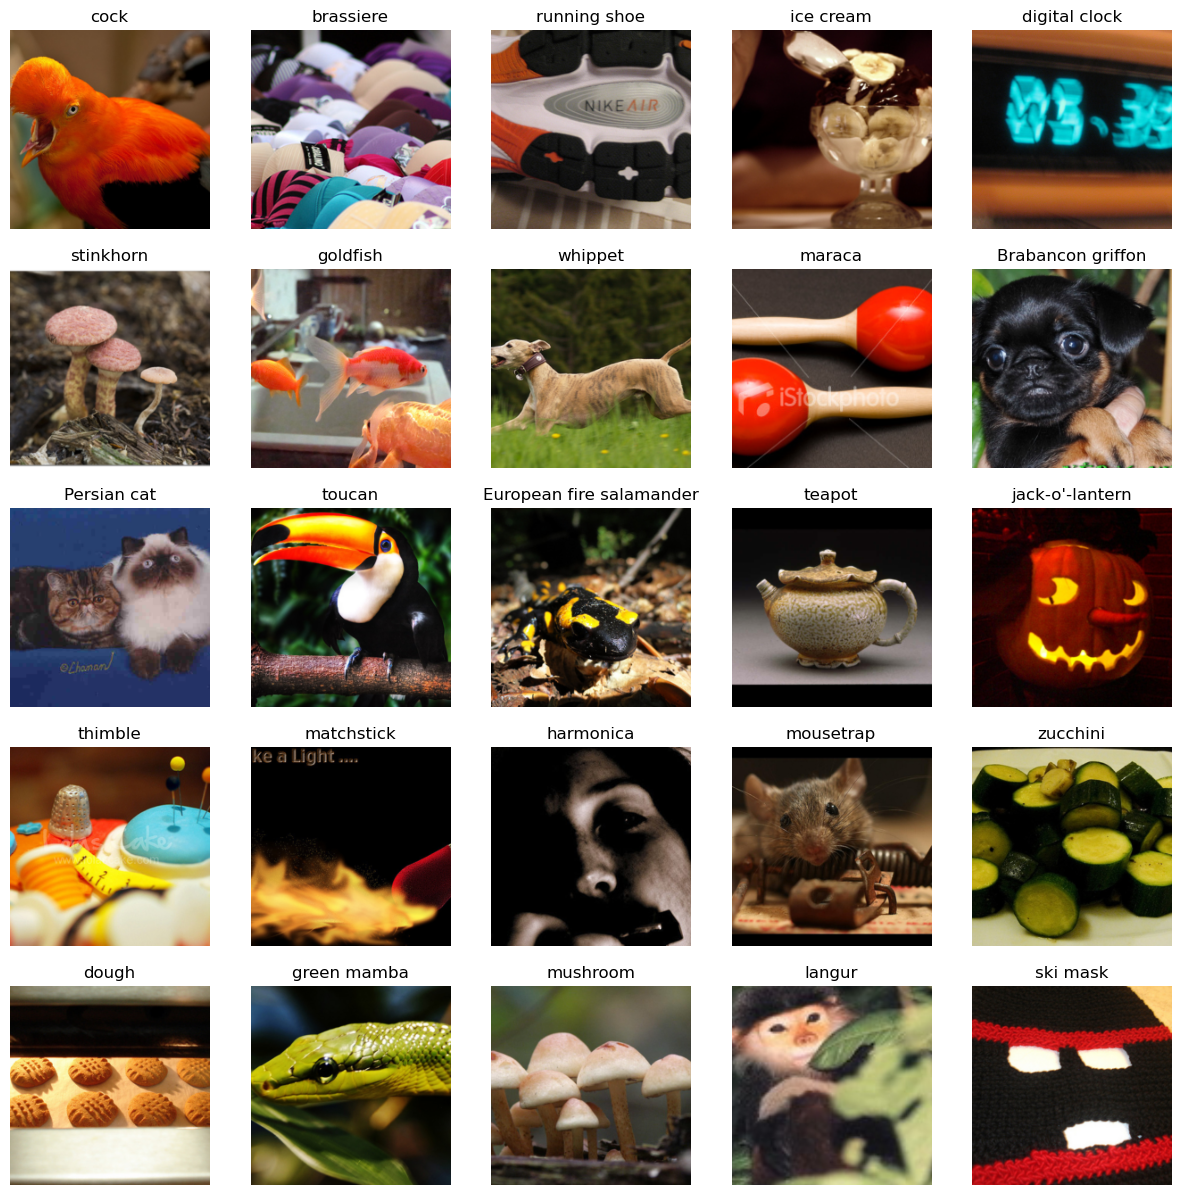

In [246]:
## Plot the 25 images that activate the most the first neuron (use dataset[idx])

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(15,15))

for i in range(5):
    for j in range(5):
        idx = sorted_idx[-(i*5+j+1)]
        img, label = val_dataset[idx]
        img = img.unsqueeze_(0)
        ## Clamp the values between 0 and 1 then 255 int
        img = unormalize(img)[0]
        axs[i, j].imshow(img.permute(1, 2, 0))
        axs[i, j].set_title(idx2classes[label].split(',')[0])
        axs[i, j].axis('off')

plt.show()

In [133]:
in_hier = ImageNetHierarchy('/tmp/imagenet/', './wordnet_data/')

72581


In [134]:
in_hier.get_descendants('n03744840')

{'n03492542', 'n03706653'}

In [135]:
## Build a "reversed" tree where each node point to all of its ancestors.
## Right now the tree is a dict with each dict corresponding to a Node. When you get a node, you have acess to all of its children

def build_reversed_tree(tree):
    reversed_tree = {}
    for node in tree:
        all_desc = tree[node].descendants_all
        for desc in all_desc:
            if desc not in reversed_tree:
                reversed_tree[desc] = []
            reversed_tree[desc].append(node)

    return reversed_tree

reversed_tree = build_reversed_tree(in_hier.tree)

In [136]:
def get_common_ancestors(node1, node2, reversed_tree):
    ancestors1 = reversed_tree[node1]
    ancestors2 = reversed_tree[node2]
    return set(ancestors1).intersection(set(ancestors2))

In [138]:
def get_wnid_from_classes_dict(in_hier):
    wnid_to_num = in_hier.wnid_to_num
    num_to_wnid = {v: k for k, v in wnid_to_num.items()}
    return num_to_wnid

def get_class_from_wnid_dict(in_hier):
    wnid_to_num = in_hier.wnid_to_num
    return wnid_to_num

In [139]:
num_to_wnid = get_wnid_from_classes_dict(in_hier)

In [140]:
## verify that the commons are coherent by printing them along with classes 0 and 1
commons= get_common_ancestors(num_to_wnid[0], num_to_wnid[1], reversed_tree)
wnid_to_name = in_hier.wnid_to_name

for c in commons:
    print(wnid_to_name[c])

wnid_to_name[num_to_wnid[0]], wnid_to_name[num_to_wnid[1]]


whole, unit
cyprinid, cyprinid fish
aquatic vertebrate
cypriniform fish
object, physical object
living thing, animate thing
bony fish
soft-finned fish, malacopterygian
vertebrate, craniate
teleost fish, teleost, teleostan
organism, being
animal, animate being, beast, brute, creature, fauna
physical entity
entity
fish
chordate


('tench, Tinca tinca', 'goldfish, Carassius auratus')

In [141]:
## verify that the commons are coherent by printing them along with classes 0 and 600
commons= get_common_ancestors(num_to_wnid[0], num_to_wnid[600], reversed_tree)
wnid_to_name = in_hier.wnid_to_name

for c in commons:
    print(wnid_to_name[c])

wnid_to_name[num_to_wnid[0]], wnid_to_name[num_to_wnid[600]]


entity
whole, unit
physical entity
object, physical object


('tench, Tinca tinca', 'hook, claw')

In [142]:
## Build a tree with each node pointing to only its father.

def build_tree_child_to_father(tree):
    child_to_father = {}
    for node in tree:
        parent = tree[node].parent_wnid
        child_to_father[node] = parent
    return child_to_father

child_to_father = build_tree_child_to_father(in_hier.tree)

In [143]:
def get_shortest_path_length(node1, node2, child_to_father):
    ancestors1 = []
    ancestors2 = []
    while True:
        try:
            ancestors1.append(node1)
            node1 = child_to_father[node1]
        except KeyError:
            break
    while True:
        try:
            ancestors2.append(node2)
            node2 = child_to_father[node2]
        except KeyError:
            break
    shortest_path = 0
    ## Get the first common ancestor and its index in each list be careful, depth might not be symetric..
    for i, a1 in enumerate(ancestors1):
        if a1 in ancestors2:
            shortest_path = i + ancestors2.index(a1)
            break
    return shortest_path


In [144]:
get_shortest_path_length(num_to_wnid[0], num_to_wnid[1], child_to_father)

2

In [145]:
get_shortest_path_length(num_to_wnid[0], num_to_wnid[600], child_to_father)

19

In [146]:
## Build a matrix D of shape (n_classes, n_classes) that corresponds to the distance in the hierarchy between each class

D = torch.zeros(1000, 1000)

for i in range(1000):
    for j in range(i):
        D[i, j] = get_shortest_path_length(num_to_wnid[i], num_to_wnid[j], child_to_father)
        D[j, i] = D[i, j]

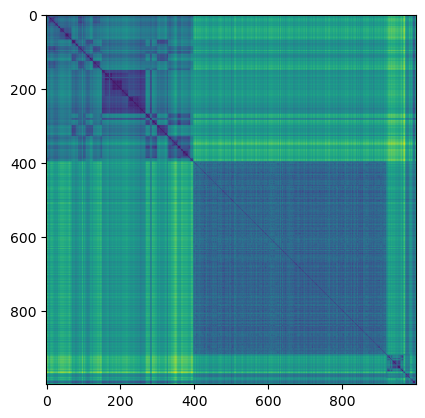

In [147]:
plt.imshow(D)

In [148]:
def polysemanticity(D, freqs):
    """
    D of shape (n_classes, n_classes)
    freqs of shape (n_channels, n_classes)
    """
    return torch.einsum('in,ij,jn->n', freqs, D, freqs)/(freqs**2).sum(dim=0)

In [149]:

def get_class_freq(feature_acts):
    ## feature_acts is of shape (n_samples, n_features)
    ## Classes are grouped by 50 instances
    features_acts_by_class = feature_acts.split(50)
    features_acts_by_class = [x.mean(dim=0) for x in features_acts_by_class]
    features_acts_by_class = torch.stack(features_acts_by_class)
    return features_acts_by_class

In [172]:
features_acts_by_class = get_class_freq(feature_acts)

In [173]:
neurons_acts_by_class = get_class_freq(neuron_acts)

In [174]:
neuron_polysemanticity = polysemanticity(D, neurons_acts_by_class)

In [175]:
feature_polysemanticity = polysemanticity(D, features_acts_by_class[:,non_dead_features])

In [176]:
neuron_polysemanticity.mean(), feature_polysemanticity.mean()

(tensor(10460.4600), tensor(7502.7334))

In [269]:
some_dog_classes_file = './utils.txt'

with open(some_dog_classes_file) as f:
    some_dog_classes = f.read().split('\n')

some_dog_classes[:5]

['Chihuahua',
 'Japanese spaniel',
 'Maltese dog, Maltese terrier, Maltese',
 'Pekinese, Pekingese, Peke',
 'Shih-Tzu']

In [270]:
dog_classes_idx = [classes2idx[c] for c in some_dog_classes if c in classes2idx]
dog_classes_idx = torch.tensor(dog_classes_idx)

is_dog = (all_classes.unsqueeze(1) == dog_classes_idx.unsqueeze(0)).any(dim=1)

In [271]:
is_dog.sum()

tensor(5000)

In [272]:
dog_feature_acts = feature_acts[is_dog]

In [273]:
dog_feature_acts.shape

torch.Size([5000, 2540])

In [274]:
## Find the 10 features that are the most activated by dogs.

features_idx = dog_feature_acts.sum(dim=0).argsort()[-10:].flip(dims=(0,))

In [275]:
dog_feature_acts.sum(dim=0)[features_idx]

tensor([17843.1895,  9842.2559,  9774.8428,  9748.6904,  9552.6387,  8337.7852,
         7431.3154,  7211.0352,  6817.4360,  6550.0420])

In [276]:
features_idx

tensor([2273, 1485, 1710, 1081,  212, 2238,    9,  387,  694, 2176])

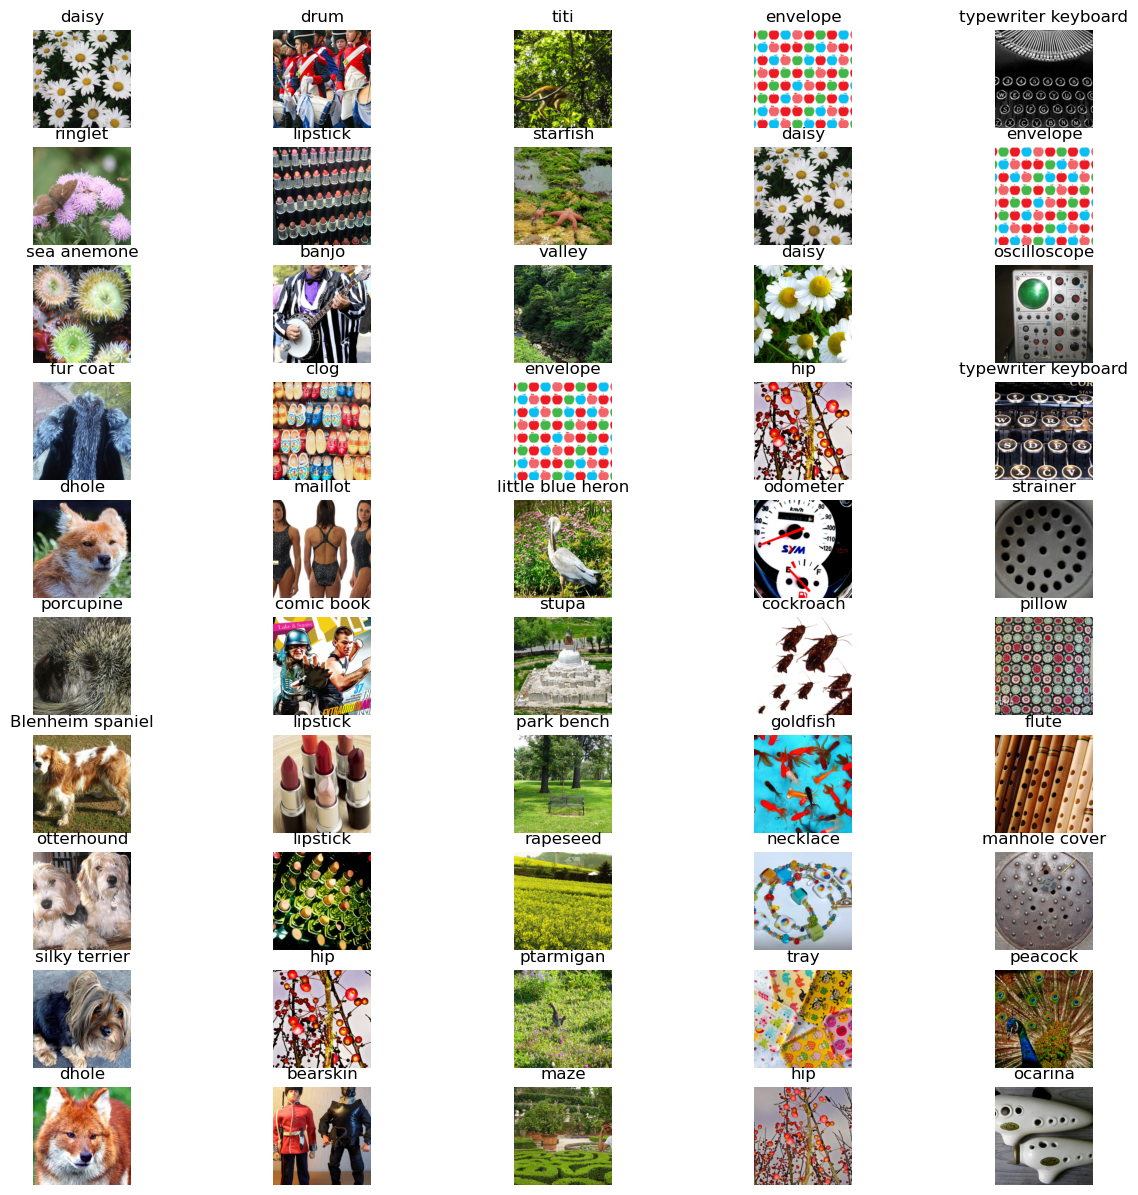

In [277]:
# For the first 5 "dog" features, find the 5 images that activate them the most (no matter whether a dog or not) and plot them (in a column).

fig, axs = plt.subplots(10, 5, figsize=(15,15))

for i in range(5):
    feature = features_idx[i]
    sorted_classes_idx = torch.argsort(feature_acts[:, feature]).flip(dims=(0,))
    for j in range(10):
        idx = sorted_classes_idx[j]
        img, label = val_dataset[idx]
        img = img.unsqueeze_(0)
        ## Clamp the values between 0 and 1 then 255 int
        img = unormalize(img)[0]
        axs[j, i].imshow(img.permute(1, 2, 0))
        axs[j, i].set_title(idx2classes[label].split(',')[0])
        axs[j, i].axis('off')